In [107]:
import numpy as np
import pandas as pd
import pandas_ta_classic as ta
import scipy
from scipy import linalg as la
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## 1. Dataset Check

In [124]:
df = yf.download("AAPL", start="2020-01-01", end="2024-12-31", auto_adjust=False)

# Flatten multi-level columns if they exist
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
df.index = pd.to_datetime(df.index)

[*********************100%***********************]  1 of 1 completed


In [125]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-02,72.468269,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03,71.763733,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06,72.335564,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07,71.995354,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08,73.153488,75.797501,76.110001,74.290001,74.290001,132079200


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-01-02 to 2024-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1257 non-null   float64
 1   Close      1257 non-null   float64
 2   High       1257 non-null   float64
 3   Low        1257 non-null   float64
 4   Open       1257 non-null   float64
 5   Volume     1257 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.7 KB


In [70]:
df.describe()

Price,Adj Close,Close,High,Low,Open,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,151.581359,154.032180,155.582687,152.301915,153.873596,9.061168e+07
std,41.855809,41.448338,41.579678,41.231458,41.389859,5.324605e+07
min,54.264339,56.092499,57.125000,53.152500,57.020000,2.323470e+07
25%,126.484421,129.619995,130.710007,127.430000,128.960007,5.546960e+07
50%,150.220779,152.740005,154.559998,150.800003,152.570007,7.629970e+07
75%,176.073013,178.850006,180.130005,177.070007,178.440002,1.077601e+08
max,257.853760,259.019989,260.100006,257.630005,258.190002,4.265100e+08


In [71]:
df.isna().sum()

Price
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [72]:
df.duplicated().sum()

np.int64(0)

In [73]:
df.shape

(1257, 6)

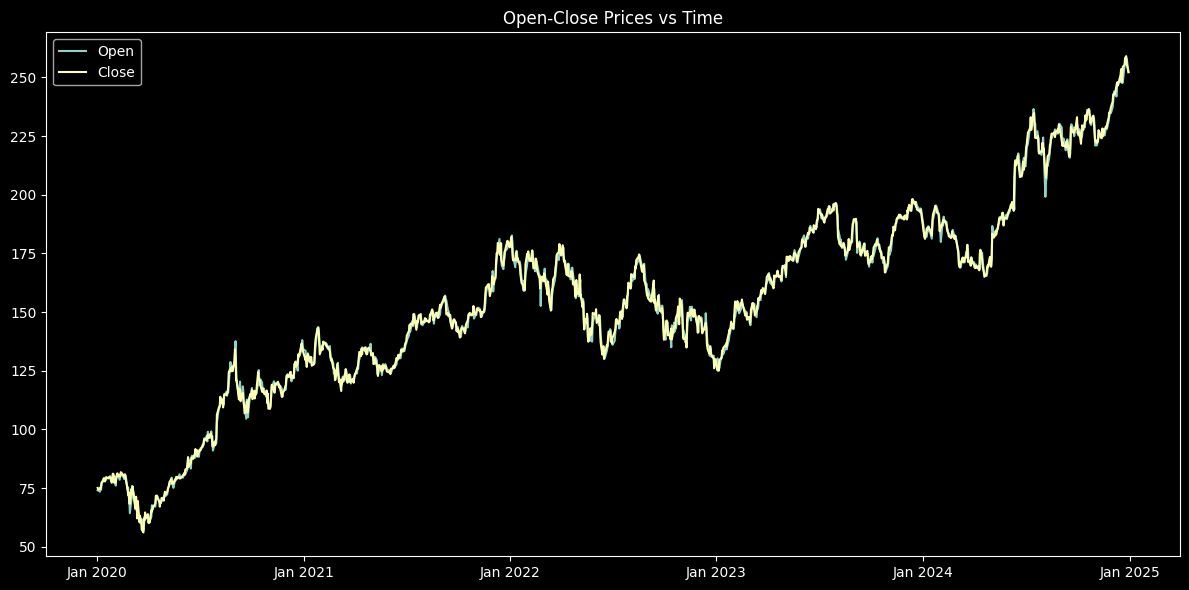

In [74]:
df.index = pd.to_datetime(df.index)

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index, df["Open"], label="Open")
ax.plot(df.index, df["Close"], label="Close")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title("Open-Close Prices vs Time")
plt.legend()
plt.tight_layout()
plt.show()

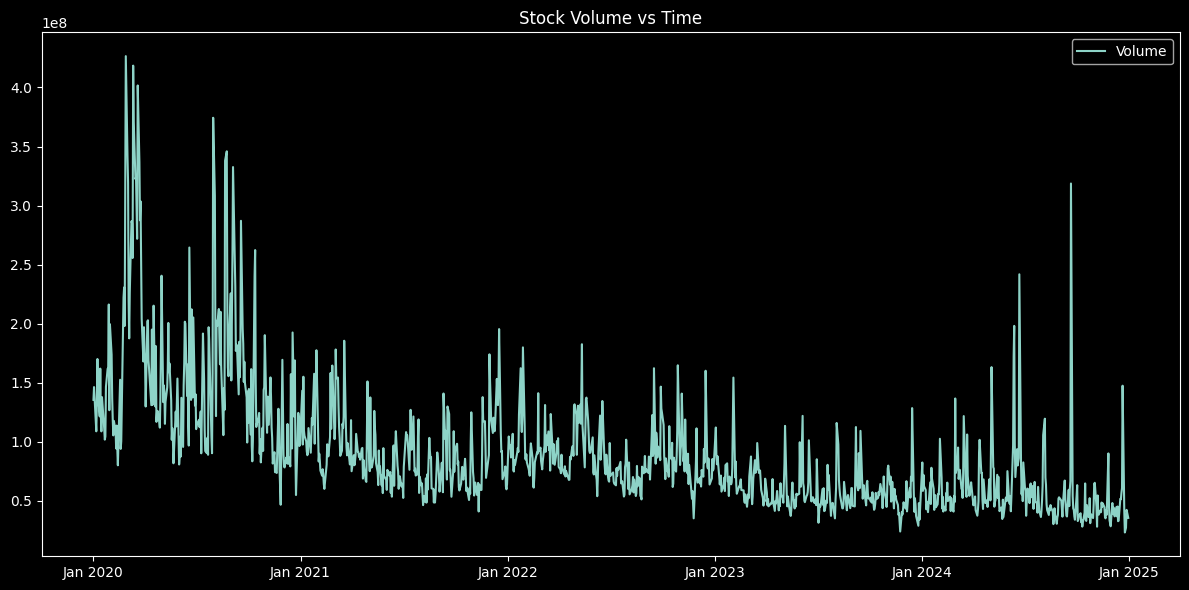

In [127]:
fig, ax = plt.subplots(figsize=(12, 6))  # Create figure + axis explicitly

ax.plot(df.index, df["Volume"], label="Volume")

# Format x-axis date ticks nicely
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title("Stock Volume vs Time")
plt.legend()
plt.tight_layout()
plt.show()

## 2. Feature Extraction

### 2.1 Momentum

In [92]:
def get_ema(data, periods=20):
    """Exponential Moving Average"""
    new_df = pd.DataFrame()
    ema = data["Adj Close"].ewm(span=periods, adjust=False).mean()
    new_df["EMA"] = (ema - ema.mean()) / ema.std()
    return new_df
    
def get_sma(data, periods=50):
    """Simple Moving Average"""
    new_df = pd.DataFrame()
    sma = data["Adj Close"].rolling(window=periods).mean()
    new_df["SMA"] = (sma - sma.mean()) / sma.std()
    return new_df

def get_rsis(data, periods=24):
    """Relative Strength Index"""
    rsi_range = list(range(2, periods + 1))
    rsis = pd.DataFrame()
    
    for p in rsi_range:
        # Calculate RSI manually
        delta = data["Close"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=p).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=p).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        rsis["RSI_" + str(p)] = rsi
    return (rsis - rsis.mean()) / rsis.std()

def get_roc(data, window=10):
    """Rate of Change"""
    new_df = pd.DataFrame()
    roc = ((data["Adj Close"] - data["Adj Close"].shift(window)) / data["Adj Close"].shift(window)) * 100
    new_df["ROC"] = (roc - roc.mean()) / roc.std()
    return new_df

def get_macd(data, fast=12, slow=26, signal=9):
    """Moving Average Convergence/Divergence"""
    new_df = pd.DataFrame()
    ema_fast = data["Close"].ewm(span=fast, adjust=False).mean()
    ema_slow = data["Close"].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    new_df["MACD"] = (macd - macd.mean()) / macd.std()
    return new_df

### 2.2 Volatility

In [76]:
def get_gkvol(df):
    """Garman-Klass Volatility"""
    new_df = pd.DataFrame()
    gkvol = (((np.log(df["High"]) - np.log(df["Low"])) ** 2) / 2) - (2 * np.log(2) - 1) * (np.log(df["Adj Close"]) - np.log(df["Open"])) ** 2
    new_df["GKvol"] = (gkvol - gkvol.mean()) / gkvol.std()
    return new_df

def get_bb(df, length=20, num_std=2):
    """Bollinger Bands"""
    new_df = pd.DataFrame(index=df.index)
    
    # Calculate using pandas
    log_close = np.log1p(df["Adj Close"])
    sma = log_close.rolling(window=length).mean()
    std = log_close.rolling(window=length).std()
    
    new_df["BB Low"] = sma - (num_std * std)
    new_df["BB Mid"] = sma
    new_df["BB High"] = sma + (num_std * std)
    
    # Normalize each band
    for col in ["BB Low", "BB Mid", "BB High"]:
        new_df[col] = (new_df[col] - new_df[col].mean()) / new_df[col].std()
    
    return new_df

def get_atr(df, length=14):
    """Average True Range"""
    new_df = pd.DataFrame()
    
    # Calculate True Range
    high_low = df["High"] - df["Low"]
    high_close = abs(df["High"] - df["Close"].shift())
    low_close = abs(df["Low"] - df["Close"].shift())
    
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    # Calculate ATR as moving average of True Range
    atr = true_range.rolling(window=length).mean()
    
    new_df["ATR"] = (atr - atr.mean()) / atr.std()
    return new_df

### 2.3 Volume Indicators

In [91]:
def get_dollarvolume(data):
    """Dollar Volume"""
    new_df = pd.DataFrame()
    dv = (data["Adj Close"] * data["Volume"]) / 1e6
    new_df["Dollar Volume"] = (dv - dv.mean()) / dv.std()
    return new_df

def get_vpt(data):
    """Volume Price Trend"""
    new_df = pd.DataFrame()
    vpt = [0]
    for i in range(1, len(data)):
        change = (data["Adj Close"].iloc[i] - data["Adj Close"].iloc[i-1]) / data["Adj Close"].iloc[i-1]
        vpt.append(vpt[-1] + data["Volume"].iloc[i] * change)
    vpt = pd.Series(vpt, index=data.index)
    new_df["VPT"] = (vpt - vpt.mean()) / vpt.std()  # Fixed: removed double assignment
    return new_df
    
def get_obv(data):
    """On-Balance Volume"""
    new_df = pd.DataFrame()
    obv = ta.obv(data["Adj Close"], data["Volume"])
    new_df["OBV"] = (obv - obv.mean()) / obv.std()
    return new_df

def get_vwap(data):
    """Volume Weighted Average Price"""
    new_df = pd.DataFrame()
    vwap = ta.vwap(data["High"], data["Low"], data["Close"], data["Volume"])
    new_df["VWAP"] = (vwap - vwap.mean()) / vwap.std()
    return new_df

def get_mfi(data, length=14):
    """Money Flow Index"""
    new_df = pd.DataFrame()
    mfi = ta.mfi(data["High"], data["Low"], data["Close"], data["Volume"], length=length)
    new_df["MFI"] = (mfi - mfi.mean()) / mfi.std()
    return new_df

### 2.4 Price Action

In [78]:
def get_price_position(data):
    """Position of close relative to high-low range"""
    new_df = pd.DataFrame()
    position = (data["Close"] - data["Low"]) / (data["High"] - data["Low"])
    new_df["price_position"] = (position - position.mean()) / position.std()
    return new_df

def get_hl_ratio(data):
    """High-Low ratio"""
    new_df = pd.DataFrame()
    hl_ratio = (data["High"] - data["Low"]) / data["Close"]
    new_df["HL_ratio"] = (hl_ratio - hl_ratio.mean()) / hl_ratio.std()
    return new_df

### 2.5 Manufactured Features

In [79]:
def get_rolling_slope(column, window=14):
    """Rolling Slope"""

    x = np.arange(window)
    new_df = pd.DataFrame()
    new_df[column.name + " _rolling slope"] = column.rolling(window).apply(lambda y: np.polyfit(x, y, 1)[0], raw=True)
    return new_df

def get_pct(column, periods=1):
    """Percentage Change"""

    new_df = pd.DataFrame()
    new_df[column.name + "_pct_change"] = column.pct_change(periods=periods) * 100
    return new_df


### 2.6 Lagged Features

In [80]:
def get_lagged_returns(data, lags=[1, 2, 3, 5, 10]):
    """Multiple lagged returns"""
    new_df = pd.DataFrame()
    returns = data["Adj Close"].pct_change()
    for lag in lags:
        lagged = returns.shift(lag)
        new_df[f"Return_Lag_{lag}"] = (lagged - lagged.mean()) / lagged.std()
    return new_df

In [94]:
def generate_all_features(data):
    """Generate all technical indicators"""
    features = pd.DataFrame(index=data.index)
    
    # Momentum
    features = pd.concat([features, get_ema(data)], axis=1)
    features = pd.concat([features, get_sma(data)], axis=1)
    features = pd.concat([features, get_rsis(data)], axis=1)
    features = pd.concat([features, get_roc(data)], axis=1)
    features = pd.concat([features, get_macd(data)], axis=1)
    
    # Volatility
    features = pd.concat([features, get_gkvol(data)], axis=1)
    features = pd.concat([features, get_bb(data)], axis=1)
    features = pd.concat([features, get_atr(data)], axis=1)
    
    # Volume
    features = pd.concat([features, get_dollarvolume(data)], axis=1)
    features = pd.concat([features, get_vpt(data)], axis=1)
    features = pd.concat([features, get_obv(data)], axis=1)
    features = pd.concat([features, get_vwap(data)], axis=1)
    features = pd.concat([features, get_mfi(data)], axis=1)

    # Price Action
    features = pd.concat([features, get_price_position(data)], axis=1)
    features = pd.concat([features, get_vwap(data)], axis=1)
    features = pd.concat([features, get_hl_ratio(data)], axis=1)

    # Slopes and changes
    features = pd.concat([features, get_rolling_slope(data["Adj Close"])], axis=1)
    features = pd.concat([features, get_pct(data["Adj Close"])], axis=1)
    
    # Lagged Features
    features = pd.concat([features, get_lagged_returns(data, lags=[1, 2, 3, 4])], axis=1)

    output = pd.concat([data, features], axis=1)

    # Drop NaN rows
    output = output.dropna()
    
    return output

In [95]:
df_transformed = generate_all_features(df)

/var/folders/2b/zvv8556n7vbfkz5g_xhjv4mc0000gn/T/ipykernel_14079/488111701.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[8.13609546e+09 9.95866171e+09 1.31303840e+10 1.09146225e+10
 9.57246791e+09 8.55243336e+09 1.09388322e+10 8.10416183e+09
 1.17127500e+10 1.28202714e+10 1.75428553e+10 1.08396009e+10
 9.55723986e+09 8.52796466e+09 7.56330556e+09 9.24903014e+09
 7.58286410e+09 1.44750001e+10 2.49780417e+10 2.34047823e+10
 1.64250464e+10 1.99976401e+10 2.50503616e+10 2.02229842e+10
 1.67697378e+10 1.74644057e+10 1.89262959e+10 1.60386279e+10
 1.06347258e+10 1.26209329e+10 1.30335613e+10 1.33589387e+10
 1.11846626e+10 1.08262088e+10 8.87439260e+09 1.38665673e+10
 1.12245008e+10 8.04597636e+09 8.65015792e+09 8.86261415e+09
 8.27087325e+09 9.85321547e+09 1.33740455e+10 1.09953979e+10
 1.07075194e+10 8.74560183e+09 1.03141450e+10 1.14239543e+10
 1.27407796e+10 1.06090261e+10 8.00840855e+09 8.87643242e

In [97]:
df_transformed.head()

,Adj Close,Close,High,Low,Open,Volume,EMA,SMA,RSI_2,RSI_3,...,MFI,price_position,VWAP,HL_ratio,Adj Close _rolling slope,Adj Close_pct_change,Return_Lag_1,Return_Lag_2,Return_Lag_3,Return_Lag_4
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-13,67.227600,69.492500,69.980003,63.237499,66.222504,370732000,-1.953871,-2.011634,-0.049060,-0.302596,...,-0.596243,1.234569,-2.086491,5.941575,-0.368301,11.980806,-5.006234,-1.799830,3.544514,-4.017991
2020-03-16,58.578972,60.552502,64.769997,60.000000,60.487499,322423600,-1.979919,-2.018850,-0.220350,-0.668290,...,-0.624934,-1.323005,-2.226452,4.487768,-0.600697,-12.864699,5.940484,-5.005860,-1.799040,3.543883
2020-03-17,61.154690,63.215000,64.402496,59.599998,61.877499,324056000,-1.997527,-2.024362,-0.783894,-0.050489,...,-0.555816,0.683393,-2.211198,4.264428,-0.674300,4.397001,-6.503405,5.938778,-5.003803,-1.798101
2020-03-18,59.657642,61.667500,62.500000,59.279999,59.942501,300233600,-2.016921,-2.030948,0.227276,-1.017157,...,-0.519156,0.647878,-2.241545,2.372099,-0.900901,-2.447968,2.142130,-6.502746,5.936510,-5.001922
2020-03-19,59.200531,61.195000,63.209999,60.652500,61.847500,271857200,-2.035526,-2.037596,-1.359751,0.062134,...,-0.025789,-1.019661,-2.228585,1.541819,-1.113295,-0.766224,-1.286178,2.141146,-6.500097,5.935175


## 3. Data Visualization

In [112]:

def get_heatmap(data, size: tuple):
    plt.figure(figsize=size)
    sns.heatmap(data.corr(), annot=True)
    plt.xlabel("Features")
    plt.ylabel("Features")
    

In [99]:
def create_return(data, horizon=1, target_type='regression'):
    """
    Create target variable for prediction
    
    Parameters:
    -----------
    data : pd.DataFrame
        Price data with 'Adj Close' column
    horizon : int
        Number of periods ahead to predict
    target_type : str
        'regression' for return prediction
        'binary' for up/down classification
        'multiclass' for multiple return buckets
    """
    df = data.copy()
    
    if target_type == 'regression':
        # Predict actual return percentage
        df['Return'] = ((df['Adj Close'].shift(-horizon) - df['Adj Close']) / df['Adj Close']) * 100
        
    elif target_type == 'binary':
        # Predict direction (0 = down, 1 = up)
        df['Return'] = (df['Adj Close'].shift(-horizon) > df['Adj Close']).astype(int)
        
    elif target_type == 'multiclass':
        # Predict return bucket (0 = big down, 1 = small down, 2 = small up, 3 = big up)
        returns = ((df['Adj Close'].shift(-horizon) - df['Adj Close']) / df['Adj Close']) * 100
        df['Return'] = pd.cut(returns, 
                              bins=[-np.inf, -1, 0, 1, np.inf], 
                              labels=[0, 1, 2, 3]).astype(int)
    
    # Drop rows with NaN target (last 'horizon' rows)
    df = df.dropna(subset=['Return'])
    
    return df

In [102]:
df_returns = create_return(df_transformed)

In [122]:
def get_dendrogram(data, size=(15, 8)):
    """
    Hierarchical clustering to identify feature groups
    Shows which features are similar and can be grouped together
    
    HOW TO USE:
    - Features that merge low (close to bottom) are highly correlated
    - Draw a horizontal line at height ~0.5 to create clusters
    - Keep only 1-2 features from each cluster to reduce redundancy
    
    WHAT TO DO:
    - If you see tight clusters of 3+ features: remove all but the best one (by MI score)
    - This prevents your model from being overwhelmed by redundant information
    """
    plt.figure(figsize=size)
    
    # Calculate correlation-based distance
    corr = data.corr().abs()
    distance = 1 - corr
    
    # Perform hierarchical clustering
    Z = linkage(distance, method='ward')
    
    dendrogram(Z, labels=data.columns, leaf_rotation=90, leaf_font_size=10)
    plt.title('Feature Dendrogram - Hierarchical Clustering', fontsize=16, pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Distance (1 - |correlation|)', fontsize=12)
    plt.axhline(y=0.5, color='r', linestyle='--', label='Suggested cutoff')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("HOW TO INTERPRET:")
    print("="*70)
    print("✓ Features merging at LOW height (< 0.3) = HIGHLY CORRELATED")
    print("  → Keep only 1 from each tight group")
    print("\n✓ Features merging at HIGH height (> 0.7) = INDEPENDENT")
    print("  → Keep these - they add unique information")
    print("\n✓ Red dashed line at 0.5 = suggested cutoff for clustering")
    print("  → Features below this line can be grouped together")
    print("="*70)

# ============================================================================
# 2. SCATTER VS TARGET - See actual relationships (MOST ACTIONABLE)
# ============================================================================
def get_scatter_vs_target(data, target_col='Return', top_n=12, size=(20, 15)):
    """
    Individual scatter plots of each feature vs target
    Shows if relationships are linear, nonlinear, or non-existent
    
    HOW TO USE:
    - Look at the shape of the scatter plot
    - Red line shows linear trend
    - If points form a pattern (even if not linear) = good feature
    - Random cloud = weak feature
    
    WHAT TO DO:
    - Keep features with ANY visible pattern (linear or curved)
    - Remove features that look like random clouds
    - Features with curves are GREAT for LSTM (captures nonlinearity)
    """
    
    X = data.drop(columns=[target_col])
    y = data[target_col]
    
    mi = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    top_features = mi_scores.nlargest(top_n).index.tolist()
    
    n_cols = 4
    n_rows = (len(top_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=size)
    axes = axes.flatten()
    
    for idx, feature in enumerate(top_features):
        ax = axes[idx]
        ax.scatter(data[feature], y, alpha=0.3, s=10, color='steelblue')
        
        # Add trend line
        z = np.polyfit(data[feature].dropna(), y[data[feature].dropna().index], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(data[feature].min(), data[feature].max(), 100)
        ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Linear trend')
        
        ax.set_xlabel(feature, fontsize=9)
        ax.set_ylabel('Return', fontsize=9)
        ax.set_title(f'{feature}\nMI: {mi_scores[feature]:.4f}', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(top_features), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Feature vs Target: Look for ANY pattern (linear or curved)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("HOW TO INTERPRET:")
    print("="*70)
    print("✓ STRONG LINEAR: Points follow red line closely")
    print("  → Good for any model, especially linear models")
    print("\n✓ CURVED PATTERN: Points form a curve (not following red line)")
    print("  → EXCELLENT for LSTM! Captures nonlinear relationships")
    print("\n✓ CLUSTERED: Points form groups or bands")
    print("  → Captures market regimes - keep it!")
    print("\n✗ RANDOM CLOUD: No pattern at all")
    print("  → Weak feature, consider removing")
    print("="*70)

# ============================================================================
# 3. PCA BIPLOT - Understand feature relationships (BEST OVERVIEW)
# ============================================================================
def get_pca_biplot(data, target_col='Return', size=(14, 10)):
    """
    PCA biplot showing both samples and feature loadings
    Shows the "big picture" of your features in 2D space
    
    HOW TO USE:
    - Arrows = features (direction shows relationship)
    - Points = individual time periods (colored by return)
    - Arrows pointing same direction = correlated features
    - Arrows pointing opposite = inversely related features
    - Long arrows = important features
    
    WHAT TO DO:
    - If multiple arrows point nearly the same way: keep only 1
    - Look for clusters of green/red points to see if features separate returns well
    - Features with short arrows contribute little - consider removing
    """
    X = data.drop(columns=[target_col])
    y = data[target_col]
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create plot
    fig, ax = plt.subplots(figsize=size)
    
    # Plot samples colored by return
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdYlGn', 
                        alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
    
    # Plot feature vectors (only top 15 to avoid clutter)
    mi = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    top_features_idx = [list(X.columns).index(f) for f in mi_scores.nlargest(15).index]
    
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    for i in top_features_idx:
        feature = X.columns[i]
        ax.arrow(0, 0, loadings[i, 0]*4, loadings[i, 1]*4, 
                head_width=0.15, head_length=0.15, fc='blue', ec='blue', alpha=0.7, linewidth=2)
        ax.text(loadings[i, 0]*4.5, loadings[i, 1]*4.5, feature, 
               fontsize=9, ha='center', va='center', fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
    ax.set_title('PCA Biplot: Feature Relationships & Sample Distribution', fontsize=14, pad=15)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
    ax.axvline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, label='Return', ax=ax)
    cbar.set_label('Return (Green=Up, Red=Down)', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("HOW TO INTERPRET:")
    print("="*70)
    print("✓ ARROWS POINTING SAME DIRECTION:")
    print("  → These features are positively correlated")
    print("  → Keep only 1-2 from each group")
    print("\n✓ ARROWS POINTING OPPOSITE DIRECTIONS:")
    print("  → These features are negatively correlated")
    print("  → Both may be useful (capture opposite signals)")
    print("\n✓ LONG ARROWS:")
    print("  → Important features that explain variance")
    print("  → Definitely keep these")
    print("\n✓ SHORT ARROWS:")
    print("  → Contribute little to variance")
    print("  → Consider removing unless high MI score")
    print("\n✓ POINT COLORS (green/red):")
    print("  → If green and red are well separated = features work well")
    print("  → If all mixed = features don't discriminate well")
    print("="*70)

def get_linear_corr(data, size: tuple):
    corr_with_target = data.corr()["Return"].sort_values(ascending=False).drop(["Return"])
    plt.figure(figsize=size)
    corr_with_target.plot(kind="bar")
    plt.title("Feature–Target Correlation")
    plt.ylabel("Correlation with Future Return")
    plt.show()
    print("\nTop correlations with future returns:")
    print(corr_with_target)

def get_mi_regression(data, size: tuple):
    X = data.drop(columns=["Return"]).fillna(0)
    y = data["Return"].fillna(0)
    
    mi = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    
    plt.figure(figsize=size)
    mi_scores.plot(kind="bar")
    plt.title("Mutual Information (Hidden Nonlinear Relationships)")
    plt.ylabel("Mutual Information Score")
    plt.show()
    
    print("\nTop mutual information scores:")
    print(mi_scores)

    

# ============================================================================
# COMPLETE ANALYSIS - Run all 3 in sequence
# ============================================================================
def run_complete_analysis(data, target_col='Return'):
    """
    Run all 3 essential visualizations in sequence
    """
    print("\n" + "="*70)
    print("RUNNING COMPLETE FEATURE ANALYSIS")
    
    print("\n\n### 1. DENDROGRAM - Find Redundant Features ###")
    get_dendrogram(data.drop(columns=[target_col]))
    
    print("\n\n### 2. SCATTER VS TARGET - See Actual Relationships ###")
    get_scatter_vs_target(data, target_col=target_col, top_n=12)
    
    print("\n\n### 3. PCA BIPLOT - Big Picture Overview ###")
    get_pca_biplot(data, target_col=target_col)
    
    print("\n\n### 4. LINEAR CORRELATION - Find Trends ###")
    get_linear_corr(data, size=(17,17))

    print("\n\n### 5. MUTUAL INFORMATION REGRESSION - Find Similarities Between Features ###")
    get_mi_regression(data, size=(17,17))




RUNNING COMPLETE FEATURE ANALYSIS


### 1. DENDROGRAM - Find Redundant Features ###


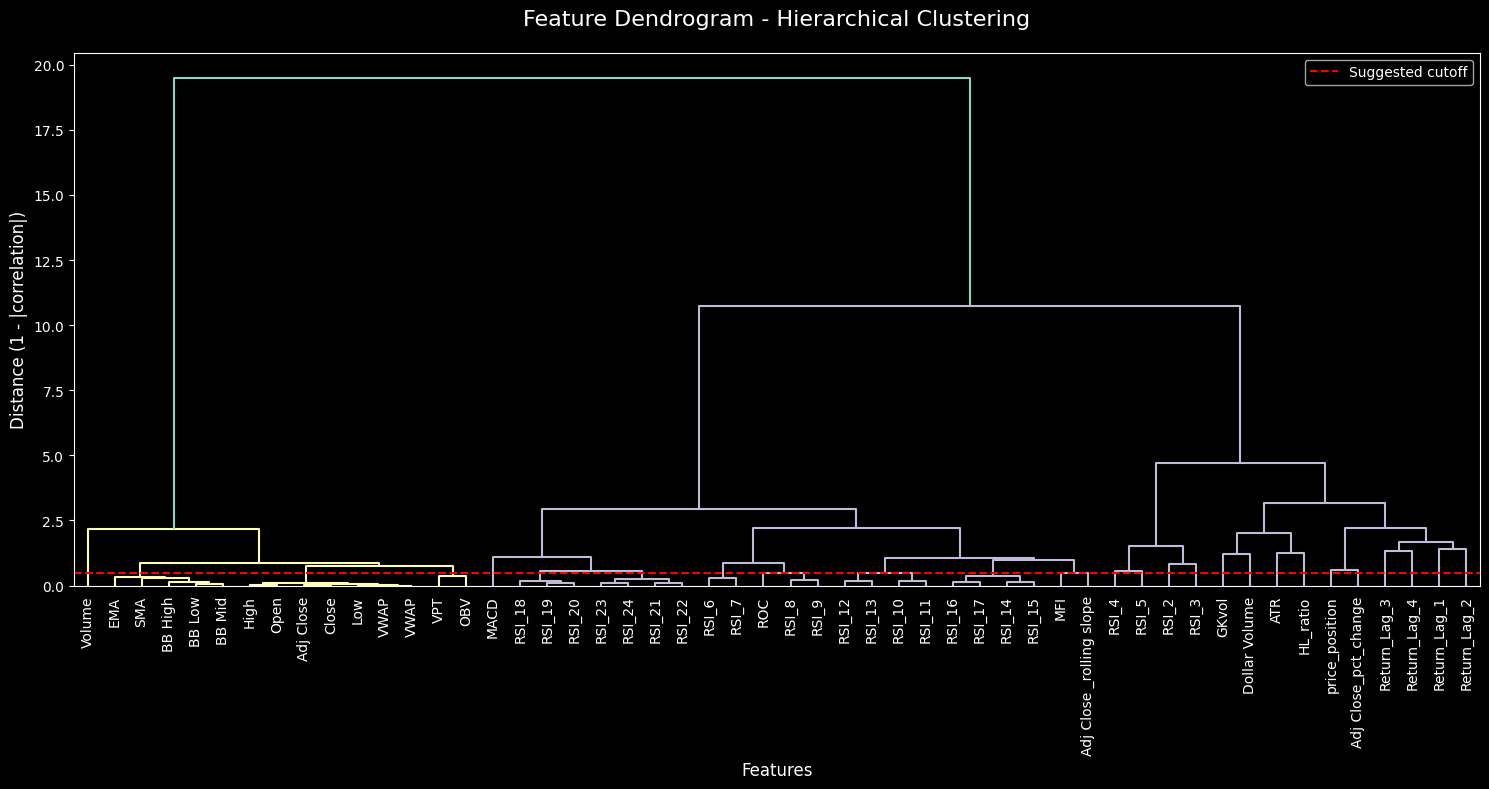


HOW TO INTERPRET:
✓ Features merging at LOW height (< 0.3) = HIGHLY CORRELATED
  → Keep only 1 from each tight group

✓ Features merging at HIGH height (> 0.7) = INDEPENDENT
  → Keep these - they add unique information

✓ Red dashed line at 0.5 = suggested cutoff for clustering
  → Features below this line can be grouped together


### 2. SCATTER VS TARGET - See Actual Relationships ###


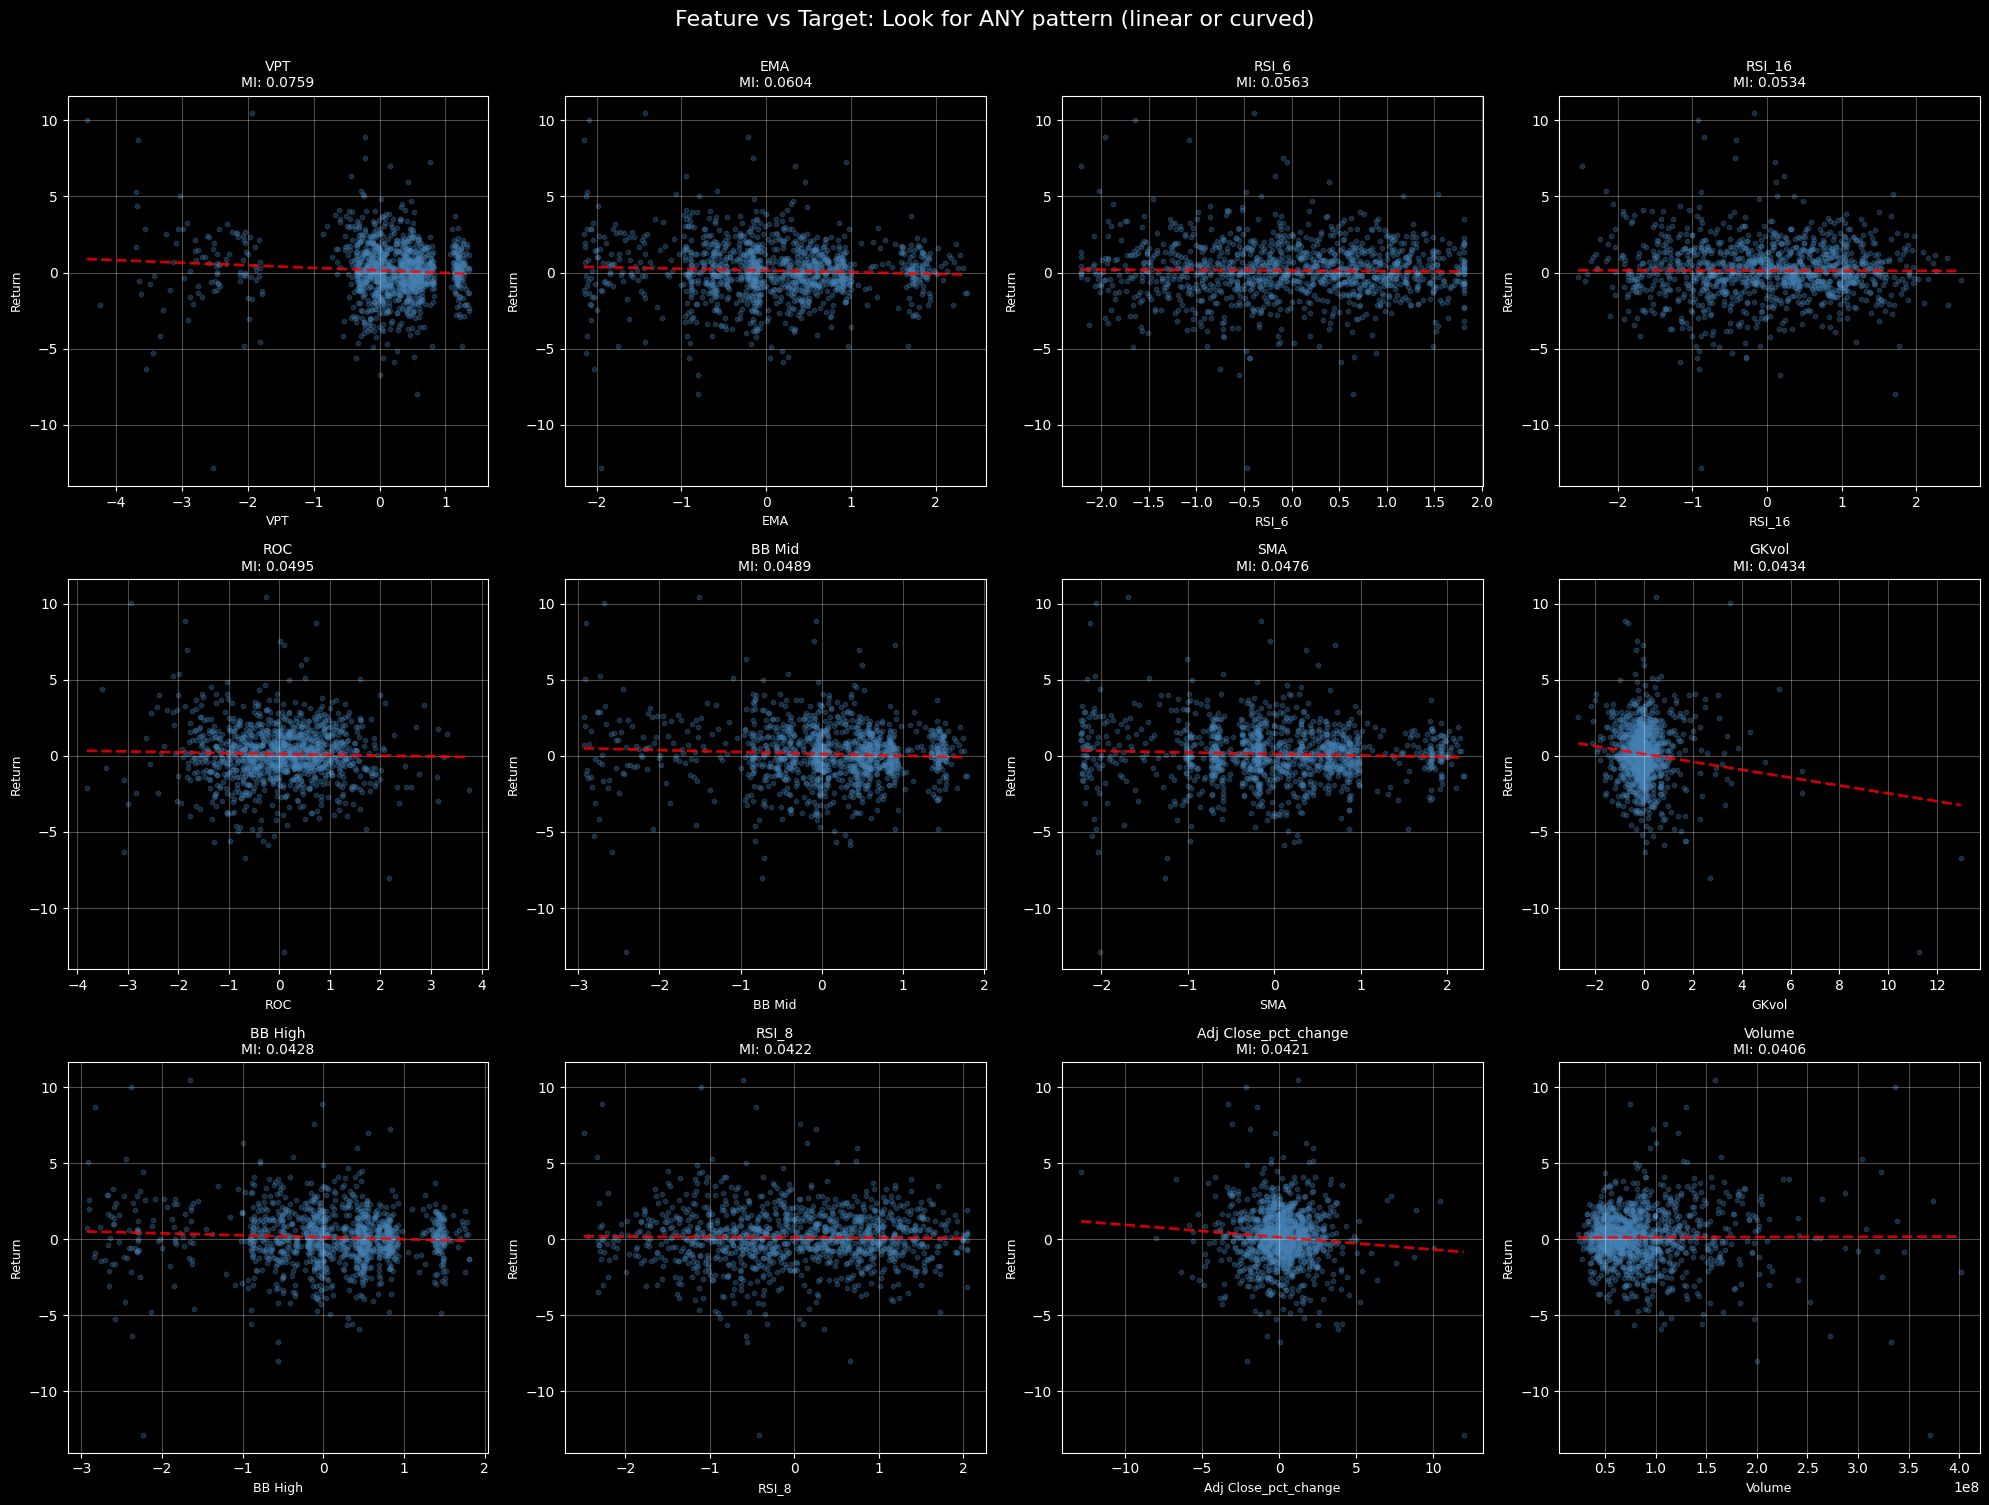


HOW TO INTERPRET:
✓ STRONG LINEAR: Points follow red line closely
  → Good for any model, especially linear models

✓ CURVED PATTERN: Points form a curve (not following red line)
  → EXCELLENT for LSTM! Captures nonlinear relationships

✓ CLUSTERED: Points form groups or bands
  → Captures market regimes - keep it!

✗ RANDOM CLOUD: No pattern at all
  → Weak feature, consider removing


### 3. PCA BIPLOT - Big Picture Overview ###


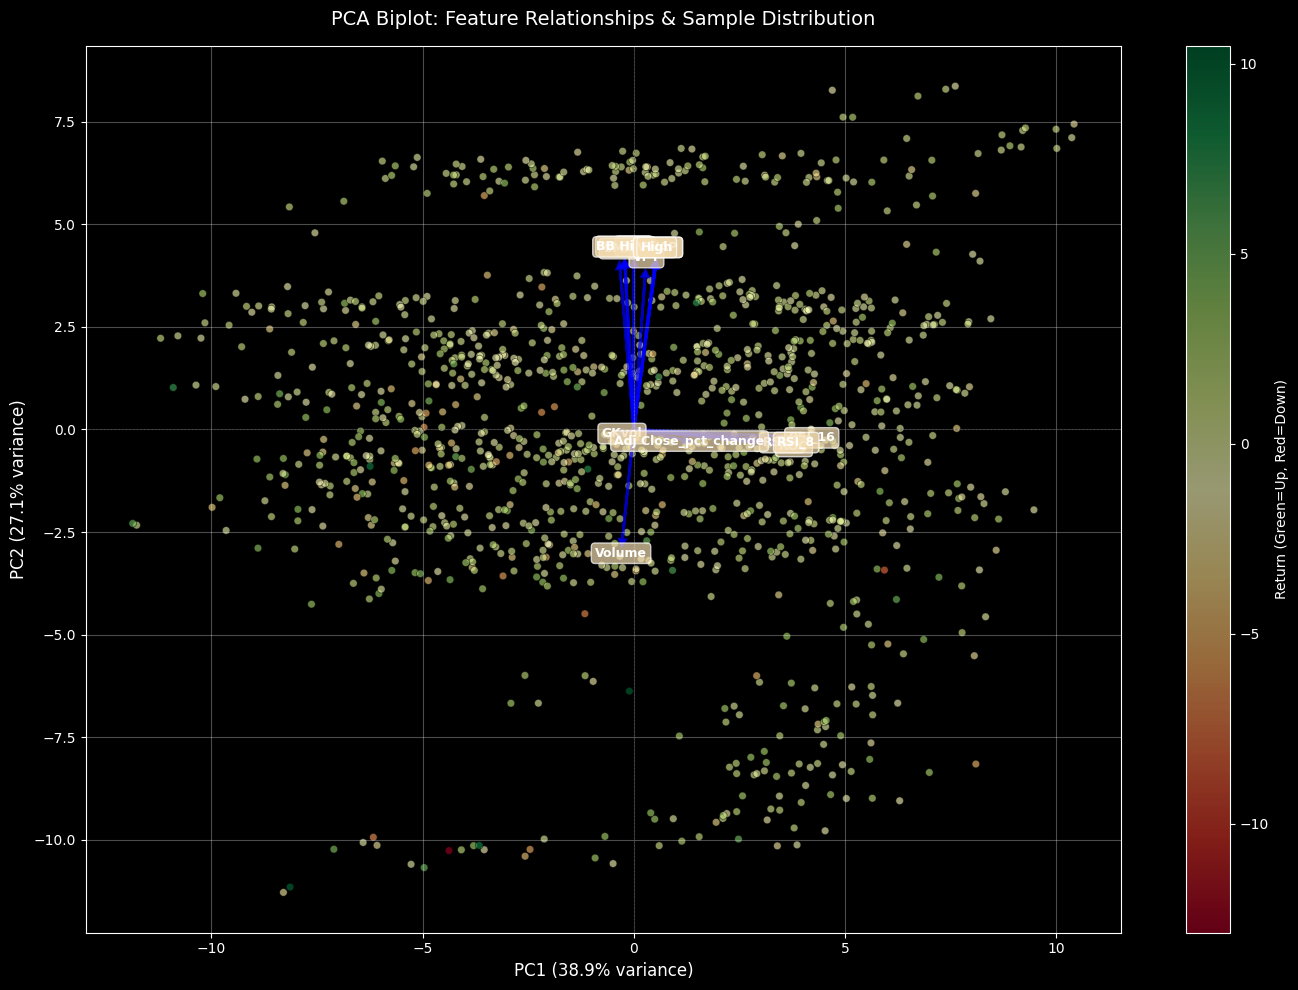


HOW TO INTERPRET:
✓ ARROWS POINTING SAME DIRECTION:
  → These features are positively correlated
  → Keep only 1-2 from each group

✓ ARROWS POINTING OPPOSITE DIRECTIONS:
  → These features are negatively correlated
  → Both may be useful (capture opposite signals)

✓ LONG ARROWS:
  → Important features that explain variance
  → Definitely keep these

✓ SHORT ARROWS:
  → Contribute little to variance
  → Consider removing unless high MI score

✓ POINT COLORS (green/red):
  → If green and red are well separated = features work well
  → If all mixed = features don't discriminate well


### 4. LINEAR CORRELATION - Find Trends ###


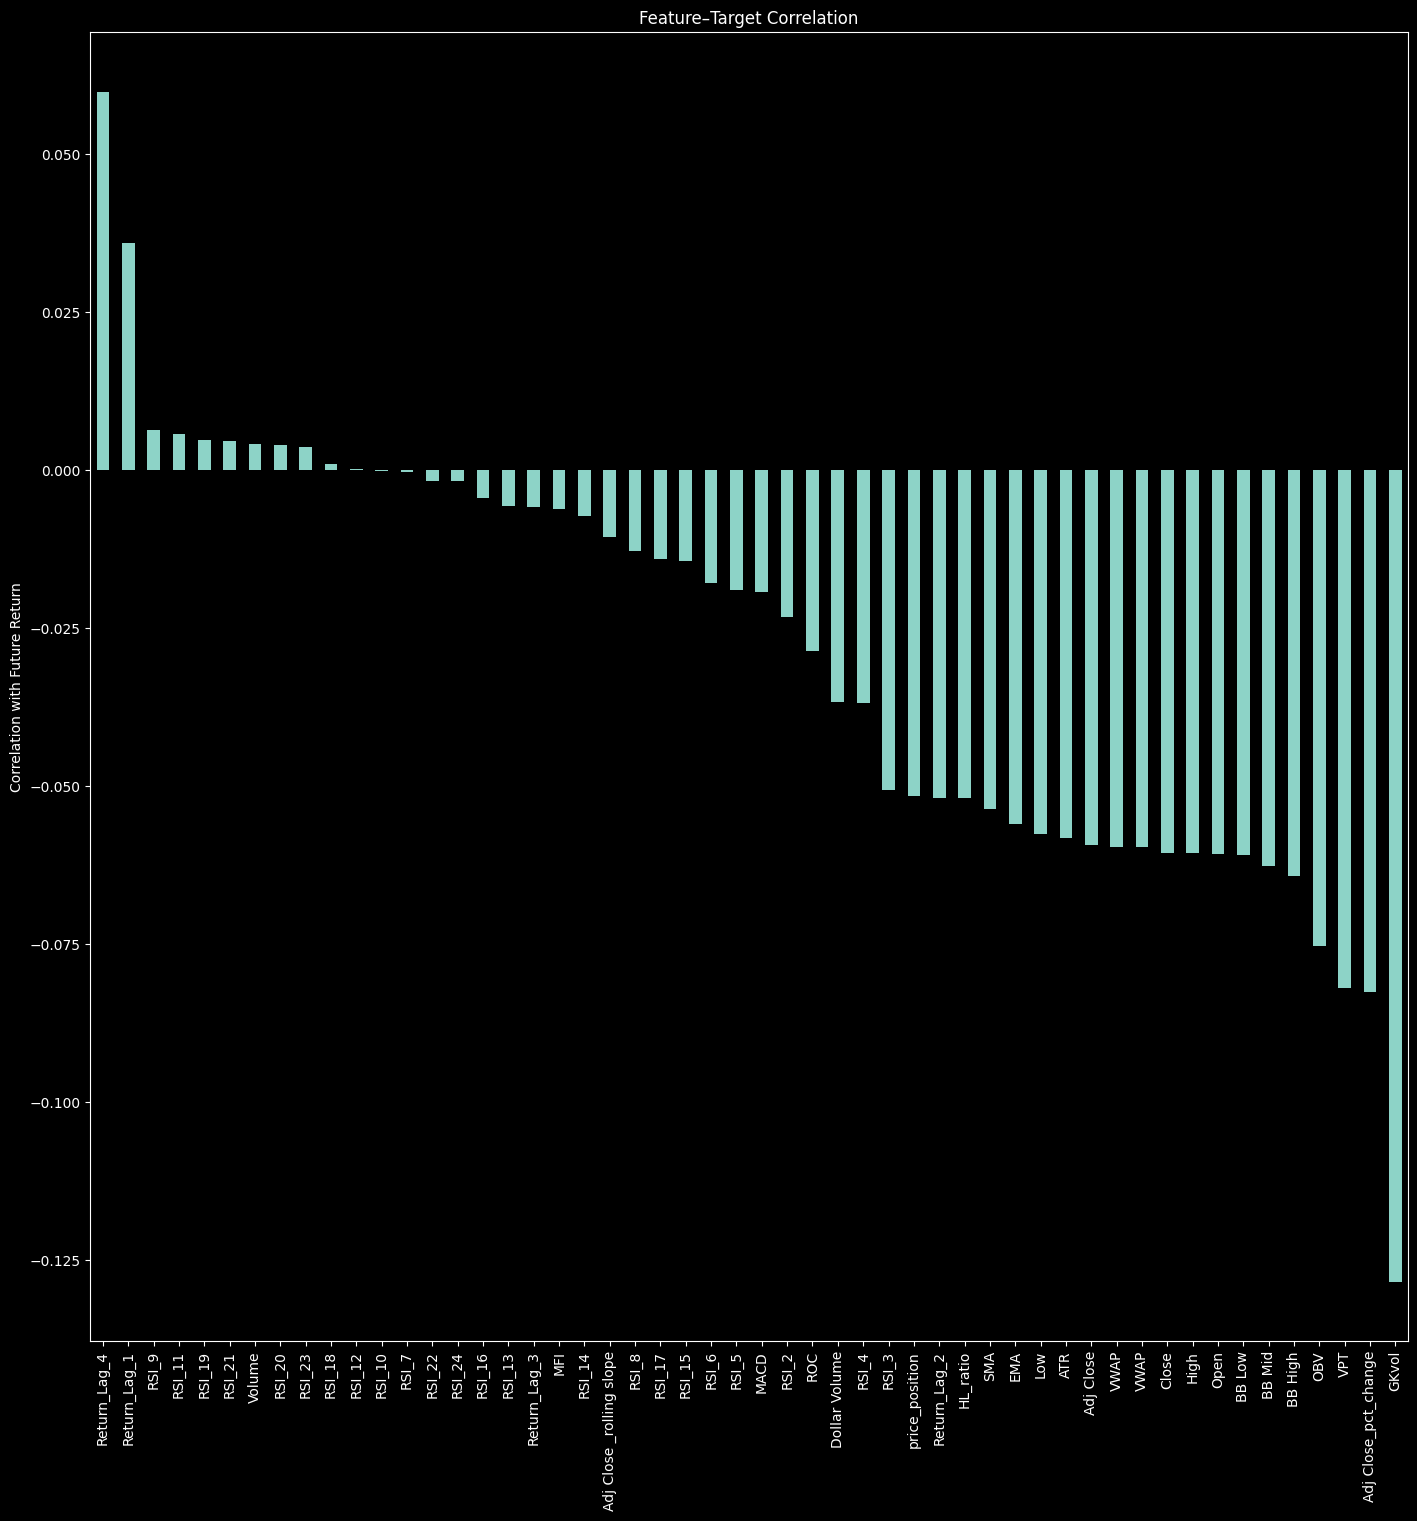


Top correlations with future returns:
Return_Lag_4                0.059892
Return_Lag_1                0.035879
RSI_9                       0.006366
RSI_11                      0.005649
RSI_19                      0.004700
RSI_21                      0.004595
Volume                      0.004170
RSI_20                      0.004026
RSI_23                      0.003604
RSI_18                      0.000996
RSI_12                      0.000254
RSI_10                     -0.000078
RSI_7                      -0.000232
RSI_22                     -0.001697
RSI_24                     -0.001736
RSI_16                     -0.004473
RSI_13                     -0.005729
Return_Lag_3               -0.005827
MFI                        -0.006212
RSI_14                     -0.007296
Adj Close _rolling slope   -0.010588
RSI_8                      -0.012835
RSI_17                     -0.013995
RSI_15                     -0.014332
RSI_6                      -0.017868
RSI_5                      -0.018914

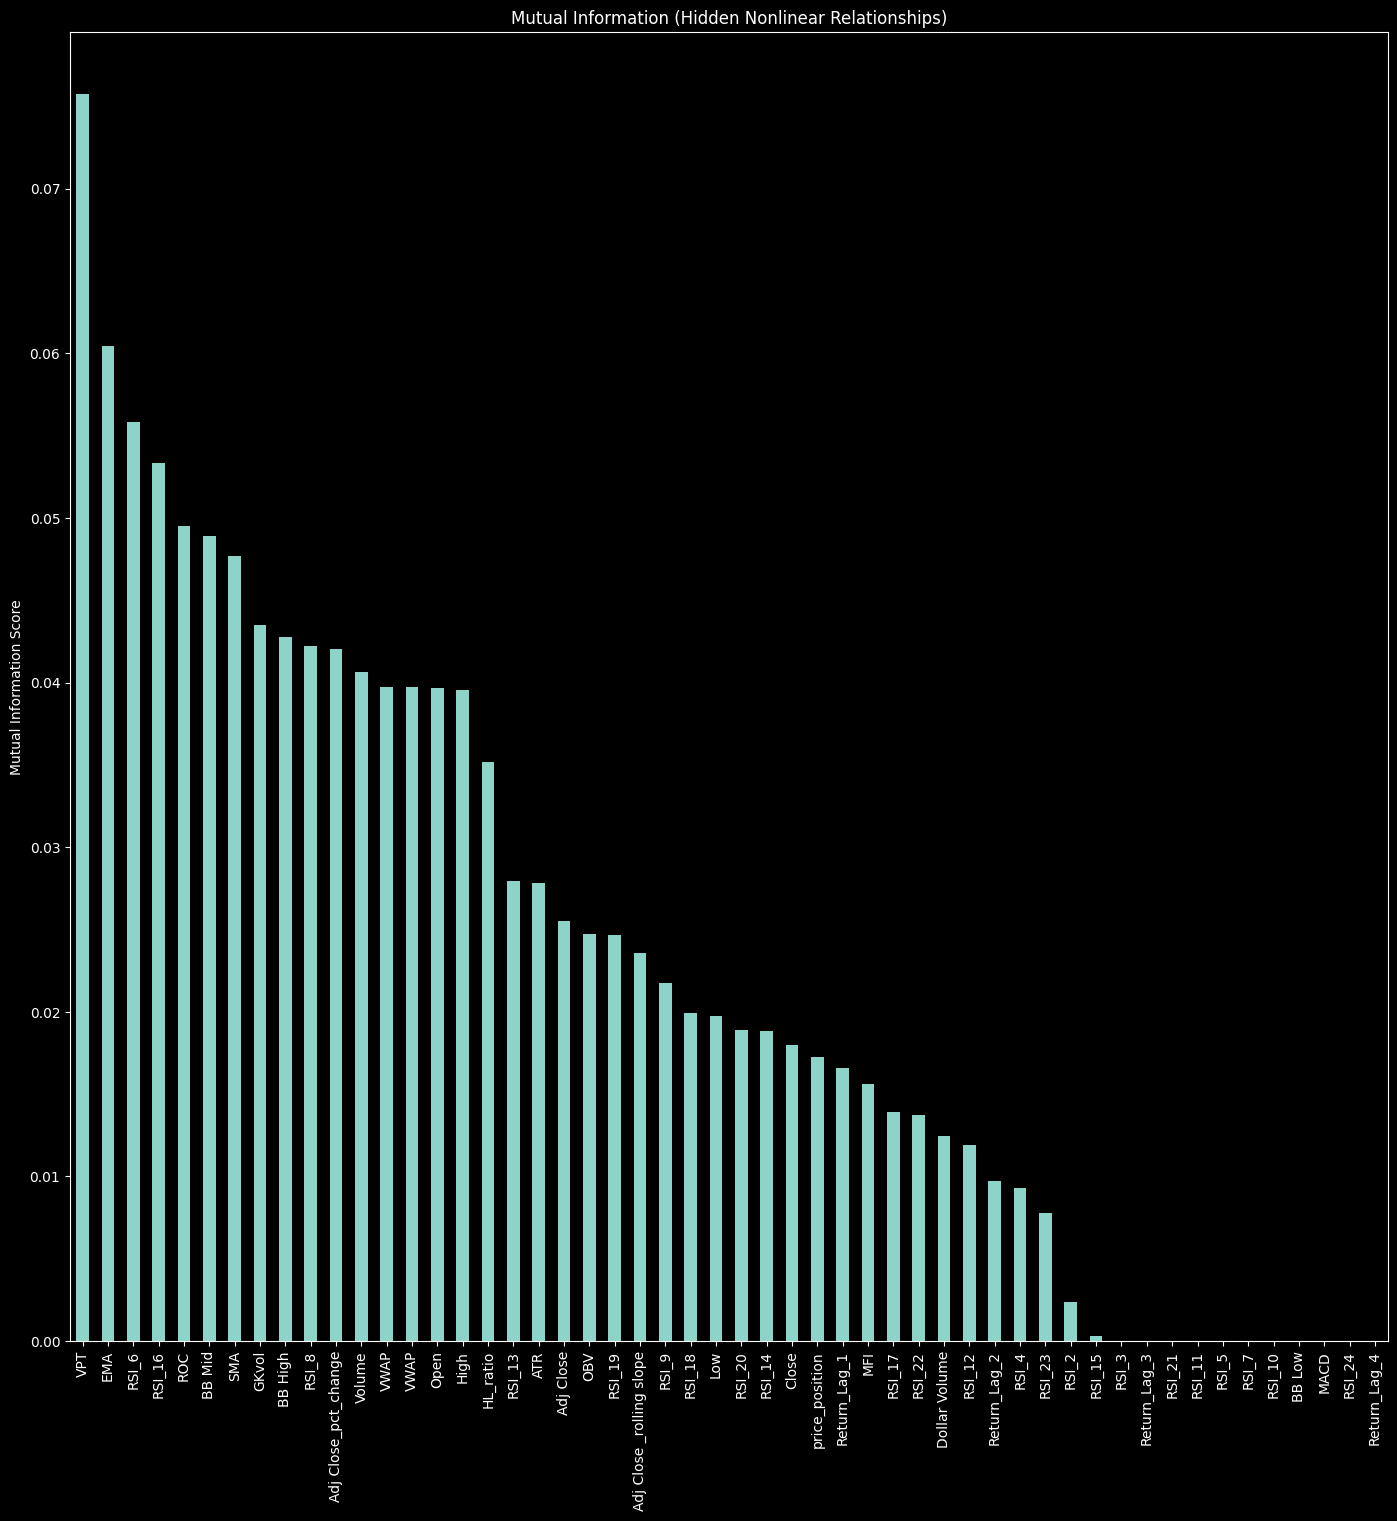


Top mutual information scores:
VPT                         0.075713
EMA                         0.060433
RSI_6                       0.055793
RSI_16                      0.053354
ROC                         0.049504
BB Mid                      0.048871
SMA                         0.047679
GKvol                       0.043465
BB High                     0.042774
RSI_8                       0.042247
Adj Close_pct_change        0.042041
Volume                      0.040611
VWAP                        0.039739
VWAP                        0.039707
Open                        0.039674
High                        0.039569
HL_ratio                    0.035152
RSI_13                      0.027940
ATR                         0.027800
Adj Close                   0.025490
OBV                         0.024739
RSI_19                      0.024681
Adj Close _rolling slope    0.023570
RSI_9                       0.021730
RSI_18                      0.019906
Low                         0.019731
RSI_20

In [123]:
run_complete_analysis(df_returns, target_col='Return')
